In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

from bams.example_systems import *
from bams.bayes_adaptor import BayesAdaptor 
from bams import convergence_analysis_tools as ctools

# Comparing BAMS with SAMS for Gaussian mixtures

This notebook compares the average rate of convergence of two Bayesian update schemes with the Rao-Blackwellized SAMS method. Because the Bayesian scheme can be computationally expensive (see this [section](#section2)), the results have been pre-calculated. SAMS results are generated in the next cell. 

The system invesitigated is a mixture of 10 Gaussian distributions centered on zero with optimally spaced spaced standard deviations between 1 and 500. Samples are generated for this system using Gibbs sampling via `GaussianMixtureSampler`. The test the impact of very correlated data on the convergence of the SAMS and BAMS schemes, the methods are updated after a single renewal of the position and state of the sampler.

In [2]:
# Generating SAMS results
niterations = 1000
repeats = 100
sigmas = ctools.gen_optimal_sigmas(s_min=1, s_max=500, N=10)

rb_mse = np.zeros((repeats,niterations))
for r in range(repeats):
    rb_mse[r,:] = ctools.rb_mse_gaussian(sigmas, niterations)

In [3]:
np.sqrt(2)*np.log(sigmas)

array([ 0.        ,  0.97653145,  1.9530629 ,  2.92959435,  3.9061258 ,
        4.88265725,  5.85918871,  6.83572016,  7.81225161,  8.78878306])

Loading BAMS data for 10 optimally spaced standard deviations between 1 and 500. Each file contains 50 repeats of 1000 iterations.

In [3]:
thompson_mse = np.load('mse_gaussian_thompson_r50_c1000.npy')
map_mse = np.load('mse_gaussian_map_r50_c1000.npy')

#### Plotting

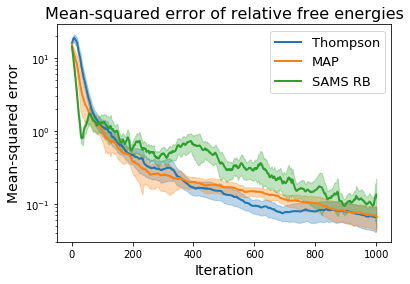

In [4]:
# Plotting parameters
alpha = 0.3           # The transparency of the spread
t = np.arange(1, niterations + 1)

# Thompson
standard_error = 2.0 * np.std(thompson_mse, axis=0) / np.sqrt(thompson_mse.shape[0])
mu = np.mean(thompson_mse, axis=0)
upper = mu + standard_error
lower = mu - standard_error
plt.semilogy(t, mu, lw=2, label='Thompson', color='C0')
plt.fill_between(t, lower, upper, alpha=alpha, color='C0')

# MAP
standard_error = 2.0 * np.std(thompson_mse, axis=0) / np.sqrt(thompson_mse.shape[0])
mu = np.mean(map_mse, axis=0)
upper = mu + standard_error
lower = mu - standard_error
plt.semilogy(t, mu, lw=2, label='MAP', color='C1')
plt.fill_between(t, lower, upper, alpha=alpha, color='C1')

# SAMS RB
standard_error = 2.0 * np.std(rb_mse, axis=0) / np.sqrt(rb_mse.shape[0])
mu = np.mean(rb_mse, axis=0)
upper = mu + standard_error
lower = mu - standard_error
plt.semilogy(t, mu, lw=2, label='SAMS RB', color='C2')
plt.fill_between(t, lower, upper, alpha=alpha, color='C2')

plt.title('Mean-squared error of relative free energies', fontsize=16)
plt.ylabel('Mean-squared error', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.legend(fontsize=13)
plt.show()

The above plot shows that the bias of the Bayesian schemes is about an order of magnitude lower than the bias in SAMS, _even with correlated samples_. It's difficult to tell on a log-plot, but it appears that SAMS has a lower variance. The total error is a sum of the bias and variance of an estimate.

$$ \text{Total error}^2 = \text{Bias}^2 + \text{Var}^2 $$

The next step is to calculate the total error at a given iteration. 

<a id='section2'></a>
## How long does it take to run the Bayesian update scheme?
The Bayesian update scheme is much computationally expensive than SAMS, which, at least with the `binary` update scheme, requires much less computational effort. Below performs a benchmark for the Bayesian scheme.

The time for the Bayesian scheme depends on the `emcee` parameters for the number of walkers (`enwalkers`) and number of moves performed by each walker (`enmoves`).

In [5]:
from time import time
from sklearn.linear_model import LinearRegression

runs = 10        # The number of iterations that will be timed
nstates = 10     # The number of Gaussians whose relative free energies will be calculated
sigmas = ctools.gen_optimal_sigmas(1, 500, nstates)      # Optimally spaced standard deviations

run_times = np.zeros(runs)
for i in range(10):
    t0 = time()
    dummy = ctools.bayes_mse_gaussian(sigmas, niterations=i, nmoves=1, save_freq=1, method='thompson', enwalkers=30, enmoves=100)
    run_times[i] = time() - t0

#### Plotting the timings and estimating the length of the simulations

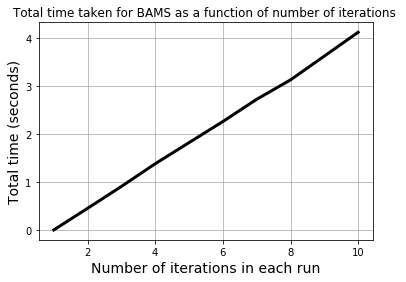

The time for 1000 iterations will be 452.52992843281135 seconds


In [6]:
t = np.arange(1, len(run_times) + 1)
plt.plot(t, run_times, lw=3, color='black')
plt.title('Total time taken for BAMS as a function of number of iterations ')
plt.xlabel('Number of iterations in each run', fontsize=14)
plt.ylabel('Total time (seconds)', fontsize=14)
plt.grid()
plt.show()

x = t.reshape(nstates,1)
fitter = LinearRegression()
fitter.fit(x, run_times)

niters = 1000
print('The time for {0} iterations will be {1} seconds'.format(niters, fitter.predict(niters)[0]))